In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor, TheilSenRegressor, RANSACRegressor, ElasticNet
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, r2_score as R2
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

df = Utils.get_final_data(df=pd.read_csv('data/train.csv'), self=None)
test = Utils.get_final_data(df=pd.read_csv('data/test.csv'), self=None)
sub = pd.read_csv('data/sample_submission.csv')

In [3]:
seed = 42
kf = KFold(n_splits=5, shuffle=True, random_state=42)


X = df.drop('yield', axis=1)
y = df['yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

df.head()

,Row#,honeybee,bumbles,andrena,osmia,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,...,clone_ratio,seed_ratio,fruitmass_per_set,honeybee_avgRD,fruitset_seeds,fruitset_seeds_fruitmass,sum_frs,fruitset_cat,fruitmass_cat,seeds_cat
0,104.0,0.25,0.25,0.25,0.75,16.00,0.26,0.477941,0.423927,34.043022,...,0.1200,71.228531,0.886986,0.0650,16.270550,34.944890,30.702307,2,2,2
1,764.0,0.00,0.00,0.00,0.00,3.77,0.06,0.334594,0.354415,27.735098,...,0.0000,82.891899,1.059240,0.0000,9.279986,28.424107,19.109720,0,0,0
2,621.0,0.50,0.25,0.75,0.63,34.00,0.56,0.468192,0.417915,34.838815,...,0.0852,74.411311,0.892615,0.2800,16.311270,35.724923,30.870949,2,2,3
3,499.0,0.50,0.25,0.38,0.75,24.00,0.39,0.500558,0.427431,35.134955,...,0.0752,70.191576,0.853909,0.1950,17.587082,36.062944,32.604845,3,2,3
4,439.0,0.25,0.38,0.50,0.75,24.00,0.39,0.520181,0.464067,37.029180,...,0.1504,71.185198,0.892126,0.0975,19.261872,38.013428,36.445887,4,6,5


In [4]:
score_results = []
def printAndSaveModelResults(model, methodName, hyperparams = None):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_score_mae = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    print(f'\nMethod: {methodName}')
    print(f'Mean Absolute Error: {cv_score_mae:.3f}')

    cv_score_r2 = cross_val_score(model, X, y, cv=kf, scoring='r2', n_jobs=-1).mean()
    print(f'R2 score: {cv_score_r2:.3f}')

    score_results.append({'MAE': cv_score_mae,
                          'R2': cv_score_r2,
                          'model': methodName,
                          'hyperparams': hyperparams})

In [5]:
pipeline_linear = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', LinearRegression())
])
printAndSaveModelResults(pipeline_linear, 'linear_robust')

pipeline_ts = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', TheilSenRegressor())
])
printAndSaveModelResults(pipeline_ts, 'theilSen_robust')

pipeline_rs = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', RANSACRegressor())
])
printAndSaveModelResults(pipeline_rs, 'ransac_robust')

pipeline_elast = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', ElasticNet())
])
printAndSaveModelResults(pipeline_elast, 'elasticnet_robust')



Method: linear_robust
Mean Absolute Error: 274.169
R2 score: 0.898

Method: theilSen_robust
Mean Absolute Error: 317.472
R2 score: 0.617

Method: ransac_robust
Mean Absolute Error: 294.023
R2 score: 0.778

Method: elasticnet_robust
Mean Absolute Error: 328.417
R2 score: 0.814


In [ ]:
pipeline_bagging = Pipeline([
    ('Model', BaggingRegressor(random_state=seed))
])
printAndSaveModelResults(pipeline_bagging, 'bagging')


Method: bagging
Mean Absolute Error: 275.570
R2 score: 0.911


In [5]:
rf_params1 = {'n_estimators': 397,
            'max_depth': 10,
            'min_samples_split': 10,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'bootstrap': False}

pipeline_rf = Pipeline([
    ('Model', RandomForestRegressor(**rf_params1, random_state=42))
])
printAndSaveModelResults(pipeline_rf, 'RandomForest', hyperparams=rf_params1)


Method: RandomForest
Mean Absolute Error: 247.343
R2 score: 0.925


# optuna

In [29]:
import optuna
from functools import partial
def objective(trial, method, X, y):
    if method == 'RandomForestRegressor':
        params = {"n_estimators": trial.suggest_int("n_estimators", 100, 400),
                "max_depth": trial.suggest_int("max_depth", 5, 20),
                "min_samples_split": trial.suggest_int("min_samples_split", 8, 25),
                "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 20),
                "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
                "max_samples": trial.suggest_float("max_samples", 0.5, 0.9),
                "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 0.2, step=0.005),
                "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5)
        }
        model = RandomForestRegressor(**params, random_state=42)
    
    elif method == 'RidgeRegressor':
        params = {
            "alpha": trial.suggest_float("alpha", 0.001, 100.0, log=True),
            "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
            "solver": trial.suggest_categorical("solver", ["auto", "svd", "cholesky", "lsqr", "sag", "saga"])
        }
        model = Ridge(**params)

    elif method == 'HuberRegressor':
        params = {
        "epsilon": trial.suggest_float("epsilon", 1.0, 10.0),
        "alpha": trial.suggest_float("alpha", 0.0001, 1.0, log=True),
        "fit_intercept": trial.suggest_categorical("fit_intercept", [True, False]),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "tol": trial.suggest_float("tol", 1e-5, 1e-3, log=True),
        "warm_start": trial.suggest_categorical("warm_start", [True, False])
        }
        model = HuberRegressor(**params)

    elif method == 'ElasticNet':
        params = {
            'alpha': trial.suggest_loguniform('alpha', 1e-5, 1),         
            'l1_ratio': trial.suggest_uniform('l1_ratio', 0, 1),         
            'max_iter': trial.suggest_categorical('max_iter', [1000, 5000, 10000]),  
            'tol': trial.suggest_loguniform('tol', 1e-5, 1e-2),         
            'selection': trial.suggest_categorical('selection', ['cyclic', 'random']) 
        }
        model = ElasticNet(**params)
    
    elif method == 'Bagging':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 10, 350),
            'max_samples': trial.suggest_float('max_samples', 0.5, 1.0),
            'max_features': trial.suggest_float('max_features', 0.5, 1.0),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'bootstrap_features': trial.suggest_categorical('bootstrap_features', [True, False]),
        }
        dt_params = {
            'max_depth': trial.suggest_int('max_depth', 3, 15)
        }
        base_estimator = DecisionTreeRegressor(**dt_params)
        model = BaggingRegressor(estimator=base_estimator, **params, random_state=42)
    

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    mean_cv_score = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_absolute_error', n_jobs=-1).mean()
    
    return mean_cv_score
    

study = optuna.create_study(direction="minimize")
study.optimize(partial(objective, method='Bagging', X=X, y=y), n_trials=50)

[I 2024-11-09 17:29:35,867] A new study created in memory with name: no-name-0eaeb71e-a1c5-4704-b456-77b22639fe2a
[I 2024-11-09 17:29:51,420] Trial 0 finished with value: 249.3793569823597 and parameters: {'n_estimators': 73, 'max_samples': 0.6554689981809961, 'max_features': 0.8785419518638705, 'bootstrap': False, 'bootstrap_features': False, 'max_depth': 7}. Best is trial 0 with value: 249.3793569823597.
[I 2024-11-09 17:30:24,771] Trial 1 finished with value: 249.8353825900327 and parameters: {'n_estimators': 263, 'max_samples': 0.7298059009549744, 'max_features': 0.5259557261928245, 'bootstrap': True, 'bootstrap_features': False, 'max_depth': 13}. Best is trial 0 with value: 249.3793569823597.
[I 2024-11-09 17:30:29,984] Trial 2 finished with value: 249.20728793704703 and parameters: {'n_estimators': 58, 'max_samples': 0.5191613355222147, 'max_features': 0.8460231320168472, 'bootstrap': False, 'bootstrap_features': True, 'max_depth': 6}. Best is trial 2 with value: 249.207287937047

In [30]:
study.best_params

{'n_estimators': 156,
 'max_samples': 0.659621128654313,
 'max_features': 0.5846355752413999,
 'bootstrap': True,
 'bootstrap_features': True,
 'max_depth': 7}

In [9]:
rf_params1 = {'n_estimators': 268,
 'max_depth': 7,
 'min_samples_split': 13,
 'min_samples_leaf': 10,
 'max_features': None,
 'max_samples': 0.5818250461230656,
 'min_impurity_decrease': 0.055,
 'min_weight_fraction_leaf': 0.0007226235667981045}

pipeline_rf = Pipeline([
    ('Model', RandomForestRegressor(**rf_params1, random_state=seed))
])
printAndSaveModelResults(pipeline_rf, 'RandomForest', hyperparams=rf_params1)


Method: RandomForest
Mean Absolute Error: 248.309
R2 score: 0.924


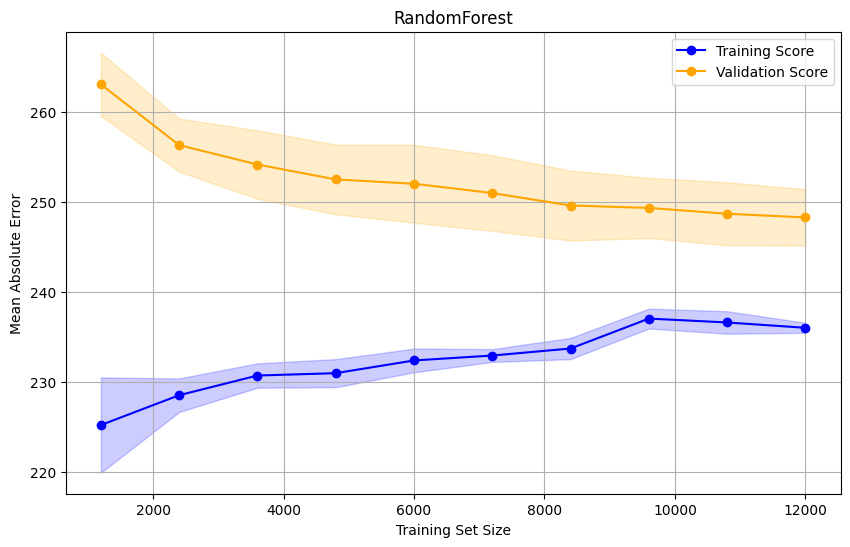

In [14]:
plot_learning_curve(pipeline_rf, X, y, model_name='RandomForest')


Method: ridge_robust
Mean Absolute Error: 269.139
R2 score: 0.909


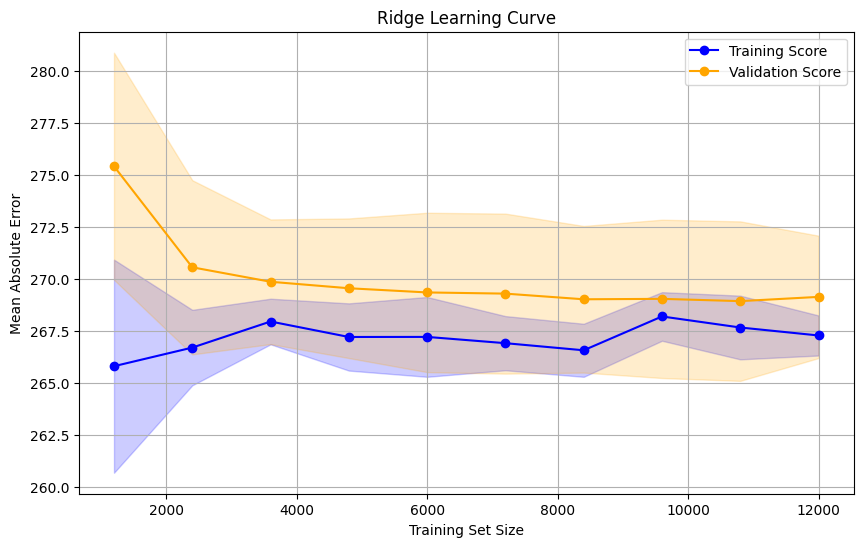

In [15]:
ridge_params = {'alpha': 0.00856065072895555, 'fit_intercept': True, 'solver': 'auto'}
pipeline_ridge = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', Ridge(**ridge_params))
])
printAndSaveModelResults(pipeline_ridge, 'ridge_robust')
plot_learning_curve(pipeline_ridge, X, y, model_name='Ridge Learning Curve')


Method: huber_robust
Mean Absolute Error: 272.465
R2 score: 0.886


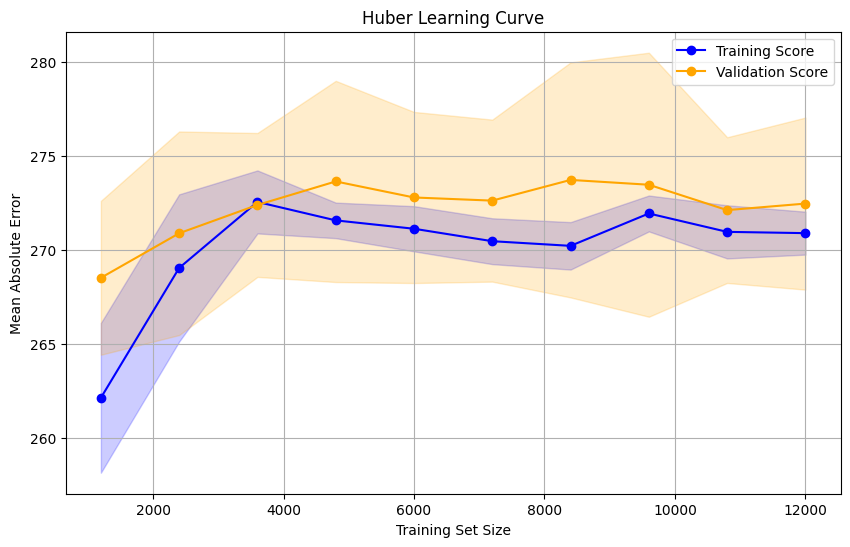

In [16]:
huber_params = {'epsilon': 1.4743037384391837,
                'alpha': 0.0008997364985513577,
                'fit_intercept': True,
                'max_iter': 700,
                'tol': 4.7218933129122393e-05,
                'warm_start': False}
pipeline_huber = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', HuberRegressor(**huber_params))
])
printAndSaveModelResults(pipeline_huber, 'huber_robust', hyperparams=huber_params)
plot_learning_curve(pipeline_huber, X, y, model_name='Huber Learning Curve')


Method: elasticnet_robust
Mean Absolute Error: 269.032
R2 score: 0.911


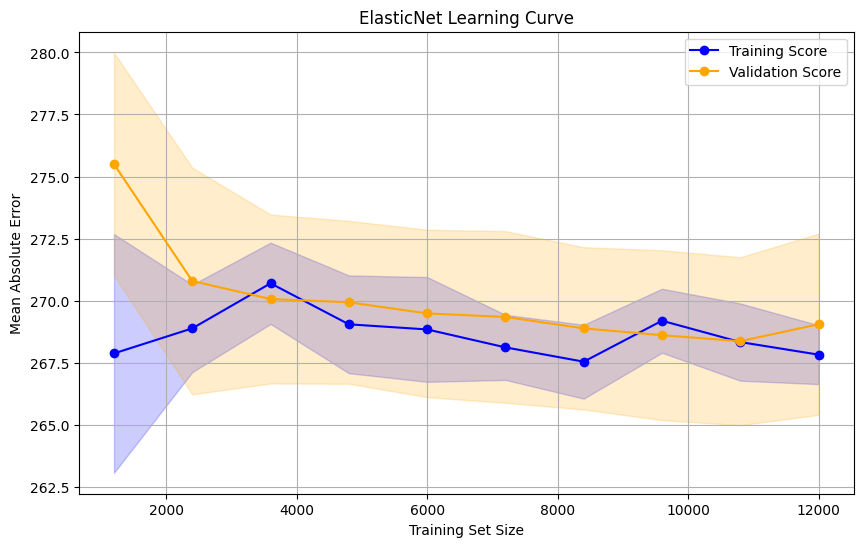

In [20]:
elast_params = {'alpha': 5.699892707713835e-05,
 'l1_ratio': 0.9982856945861646,
 'max_iter': 5000,
 'tol': 2.5429621690102518e-05,
 'selection': 'random'}
pipeline_elast = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', ElasticNet(**elast_params))
])
printAndSaveModelResults(pipeline_elast, 'elasticnet_robust')
plot_learning_curve(pipeline_elast, X, y, model_name='ElasticNet Learning Curve')


Method: bagging
Mean Absolute Error: 247.823
R2 score: 0.924


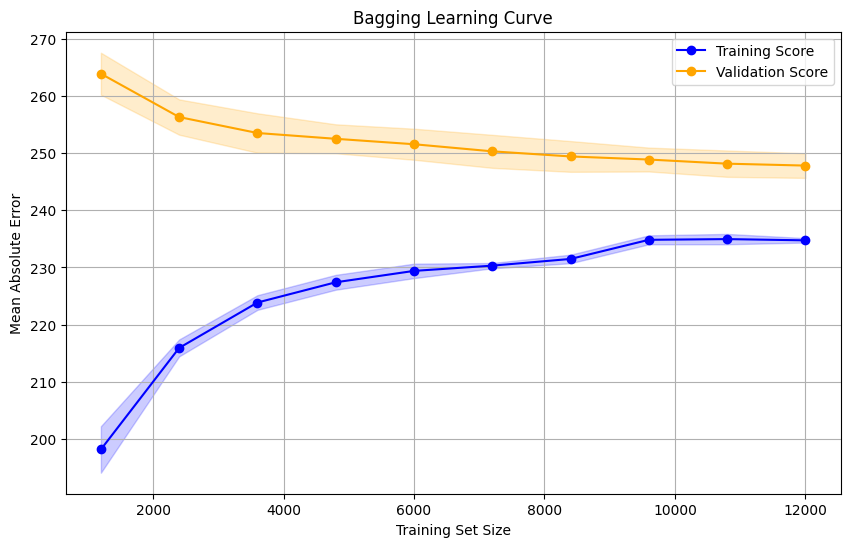

In [33]:
bagging_params = {'n_estimators': 156,
 'max_samples': 0.659621128654313,
 'max_features': 0.5846355752413999,
 'bootstrap': True,
 'bootstrap_features': True}
pipeline_bagging = Pipeline([
    ('Model', BaggingRegressor(**bagging_params, estimator=DecisionTreeRegressor(max_depth=7), random_state=seed))
])
printAndSaveModelResults(pipeline_bagging, 'bagging', hyperparams=bagging_params)
plot_learning_curve(pipeline_bagging, X, y, model_name='Bagging Learning Curve')

In [67]:
def plot_learning_curve(model, X, y, model_name = 'Learning Curve'):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=kf, scoring="neg_mean_absolute_error", train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )

    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    val_mean = -np.mean(val_scores, axis=1)
    val_std = -np.std(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Training Score", color="blue", marker='o')
    plt.plot(train_sizes, val_mean, label="Validation Score", color="orange", marker='o')

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="orange", alpha=0.2)
    plt.title(model_name)
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Absolute Error")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [62]:
huber_params = {'epsilon': 1.4743037384391837,
                'alpha': 0.0008997364985513577,
                'fit_intercept': True,
                'max_iter': 700,
                'tol': 4.7218933129122393e-05,
                'warm_start': False}
pipeline_huber = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', HuberRegressor(**huber_params))
])
ridge_params = {'alpha': 0.00856065072895555, 'fit_intercept': True, 'solver': 'auto'}
pipeline_ridge = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', Ridge(**ridge_params))
])
rf_params1 = {'n_estimators': 268,
 'max_depth': 7,
 'min_samples_split': 13,
 'min_samples_leaf': 10,
 'max_features': None,
 'max_samples': 0.5818250461230656,
 'min_impurity_decrease': 0.055,
 'min_weight_fraction_leaf': 0.0007226235667981045}
pipeline_rf = Pipeline([
    ('Model', RandomForestRegressor(**rf_params1, random_state=seed))
])
pipeline_linear = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', LinearRegression())
])
elast_params = {'alpha': 5.699892707713835e-05,
 'l1_ratio': 0.9982856945861646,
 'max_iter': 5000,
 'tol': 2.5429621690102518e-05,
 'selection': 'random'}
pipeline_elast = Pipeline([
    ('Scaler', RobustScaler()),
    ('Model', ElasticNet(**elast_params))
])
bagging_params = {'n_estimators': 156,
 'max_samples': 0.659621128654313,
 'max_features': 0.5846355752413999,
 'bootstrap': True,
 'bootstrap_features': True}
pipeline_bagging = Pipeline([
    ('Model', BaggingRegressor(**bagging_params, estimator=DecisionTreeRegressor(max_depth=7), random_state=seed))
])


estimators = [
    ('rf', pipeline_rf),
    # ('huber', pipeline_huber),
    # ('ridge', pipeline_ridge),
    ('linear', pipeline_linear),
    ('bagging', pipeline_bagging),
    # ('elast', pipeline_elast),
    # ('knn', KNeighborsRegressor()),
    # ('svr', SVR()),
    # ('extratree', ExtraTreesRegressor())
]

In [63]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor

In [64]:
stacking = StackingRegressor(
    estimators=estimators,
    final_estimator=pipeline_rf,
    cv=kf,
    n_jobs=-1,
    passthrough=True
)
stacking.fit(X_train, y_train)

StackingRegressor(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                  estimators=[('rf',
                               Pipeline(steps=[('Model',
                                                RandomForestRegressor(max_depth=7,
                                                                      max_features=None,
                                                                      max_samples=0.5818250461230656,
                                                                      min_impurity_decrease=0.055,
                                                                      min_samples_leaf=10,
                                                                      min_samples_split=13,
                                                                      min_weight_fraction_leaf=0.0007226235667981045,
                                                                      n_estimators=268,
                                                                      random_state=42))])),
                              ('...
                                                                 max_samples=0.659621128654313,
                                                                 n_estimators=156,
                                                                 random_state=42))]))],
                  final_estimator=Pipeline(steps=[('Model',
                                                   RandomForestRegressor(max_depth=7,
                                                                         max_features=None,
                                                                         max_samples=0.5818250461230656,
                                                                         min_impurity_decrease=0.055,
                                                                         min_samples_leaf=10,
                                                                         min_samples_split=13,
                                                                         min_weight_fraction_leaf=0.0007226235667981045,
                                                                         n_estimators=268,
                                                                         random_state=42))]),
                  n_jobs=-1, passthrough=True)

In [65]:
y_pred = stacking.predict(X_test)
MAE(y_test, y_pred)

246.08089874114174

In [ ]:
plot_learning_curve(stacking, X, y, model_name = 'Stacking LC')